# Twitter Sentiment Analysis

In [80]:
!pip install gensim --upgrade
!pip install keras==2.1.5
!pip install pandas --upgrade

Requirement already up-to-date: gensim in c:\users\hp\appdata\local\programs\python\python36\lib\site-packages (3.8.1)
Requirement already up-to-date: pandas in c:\users\hp\appdata\local\programs\python\python36\lib\site-packages (1.0.1)


In [132]:
# DataFrame
import pandas as pd
import random

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [133]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [246]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 1
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model_final.h5"
WORD2VEC_MODEL = "model_final.w2v"
TOKENIZER_MODEL = "tokenizer_final.pkl"
ENCODER_MODEL = "encoder_final.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [135]:
# dataset_filename = os.listdir("../input")[0]
# dataset_path = os.path.join("..","input",dataset_filename)
# print("Open file:", dataset_path)
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [136]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [139]:
df_pos = df[df['target'] == 0] 
df_neg = df[df['target'] == 4] 

df_pos=df_pos[0:50000]
df_neg=df_neg[0:50000]

print(df_pos.shape)
print(df_neg.shape)

df=pd.concat([df_pos,df_neg])
df=df.sample(frac=1)
df=df.drop(['date','flag'],axis=1)
df.shape

(50000, 6)
(50000, 6)


(100000, 4)

In [140]:
df.shape

(100000, 4)

In [88]:
df.head

<bound method NDFrame.head of         target         ids                          date      flag  \
838409       4  1559069283  Sun Apr 19 10:10:27 PDT 2009  NO_QUERY   
810354       4  1469758223  Tue Apr 07 07:19:59 PDT 2009  NO_QUERY   
843959       4  1563972706  Mon Apr 20 01:07:41 PDT 2009  NO_QUERY   
830352       4  1557296915  Sun Apr 19 03:13:29 PDT 2009  NO_QUERY   
15824        0  1554519278  Sat Apr 18 17:13:04 PDT 2009  NO_QUERY   
...        ...         ...                           ...       ...   
831011       4  1557387627  Sun Apr 19 03:48:17 PDT 2009  NO_QUERY   
831685       4  1557482871  Sun Apr 19 04:23:14 PDT 2009  NO_QUERY   
39370        0  1573511982  Tue Apr 21 01:31:10 PDT 2009  NO_QUERY   
22081        0  1557409689  Sun Apr 19 03:56:41 PDT 2009  NO_QUERY   
809453       4  1469475691  Tue Apr 07 06:29:52 PDT 2009  NO_QUERY   

                   user                                               text  
838409      kerryetches                         Hell

In [89]:
df.head(5)

,target,ids,date,flag,user,text
838409,4,1559069283,Sun Apr 19 10:10:27 PDT 2009,NO_QUERY,kerryetches,Hello to my new followers
810354,4,1469758223,Tue Apr 07 07:19:59 PDT 2009,NO_QUERY,deedoes06,last full day in menom till next week!!! lets ...
843959,4,1563972706,Mon Apr 20 01:07:41 PDT 2009,NO_QUERY,panina,@aplusk fantastic!i wanna be the record-woman ...
830352,4,1557296915,Sun Apr 19 03:13:29 PDT 2009,NO_QUERY,Meisem,Goooooooood morning all twitters The time in ...
15824,0,1554519278,Sat Apr 18 17:13:04 PDT 2009,NO_QUERY,cjclowers,Everyone is gone home - What a fun day! Too q...


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [90]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [91]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 80 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

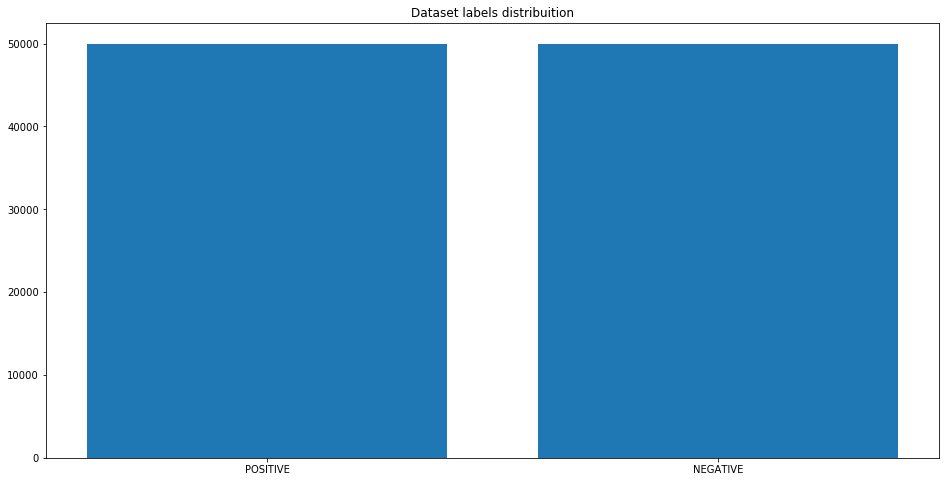

In [92]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [141]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [142]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [143]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 5.64 s


### Split train and test

In [145]:
#df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
df_train=df
print("TRAIN size:", len(df_train))

TRAIN size: 100000


In [146]:
df_train

,target,ids,user,text
809057,4,1469369021,ICETWICE,figured add twitter ad header wordpress blog g...
816509,4,1551459671,_kimberly,wait told josh get home later year dapat mag b...
844183,4,1564007402,Donnette,welcome
822426,4,1554526284,jacobjanzen,oh know cause 1337
24242,0,1557940421,chingks_baybeh,awwwwwwww poor madonna mean
...,...,...,...,...
3055,0,1468507632,43342059,pissed running old man tried trash tent left b...
33324,0,1564478955,den_26,ugh everything remind quot quot
19719,0,1556918731,Monkeygrrrl79,absolution closed days work
40490,0,1573800031,suzanne_xx,geez holidays goes fast


### Word2Vec 

In [147]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 3.35 s


In [148]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [149]:
w2v_model.build_vocab(documents)

2020-03-07 01:51:58,636 : INFO : collecting all words and their counts
2020-03-07 01:51:58,723 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-03-07 01:51:58,801 : INFO : PROGRESS: at sentence #10000, processed 71457 words, keeping 13540 word types
2020-03-07 01:51:58,842 : INFO : PROGRESS: at sentence #20000, processed 142664 words, keeping 20738 word types
2020-03-07 01:51:58,888 : INFO : PROGRESS: at sentence #30000, processed 214065 words, keeping 26666 word types
2020-03-07 01:51:58,928 : INFO : PROGRESS: at sentence #40000, processed 284838 words, keeping 31578 word types
2020-03-07 01:51:58,973 : INFO : PROGRESS: at sentence #50000, processed 356339 words, keeping 36162 word types
2020-03-07 01:51:59,005 : INFO : PROGRESS: at sentence #60000, processed 428221 words, keeping 40370 word types
2020-03-07 01:51:59,058 : INFO : PROGRESS: at sentence #70000, processed 499443 words, keeping 44395 word types
2020-03-07 01:51:59,090 : INFO : PROGRESS: at s

In [150]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 6349


In [151]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-03-07 01:52:10,428 : INFO : training model with 8 workers on 6349 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-03-07 01:52:11,744 : INFO : EPOCH 1 - PROGRESS: at 68.65% examples, 384416 words/s, in_qsize 16, out_qsize 0
2020-03-07 01:52:12,057 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-07 01:52:12,069 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-07 01:52:12,077 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-07 01:52:12,087 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-07 01:52:12,097 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-07 01:52:12,113 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-07 01:52:12,122 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-07 01:52:12,126 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-0

2020-03-07 01:52:24,799 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-07 01:52:24,810 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-07 01:52:24,843 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-07 01:52:24,857 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-07 01:52:24,861 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-07 01:52:24,864 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-07 01:52:24,866 : INFO : EPOCH - 9 : training on 714401 raw words (574080 effective words) took 1.4s, 398561 effective words/s
2020-03-07 01:52:25,898 : INFO : EPOCH 10 - PROGRESS: at 65.86% examples, 373368 words/s, in_qsize 14, out_qsize 1
2020-03-07 01:52:26,132 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-07 01:52:26,174 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-07 01:52:26,17

2020-03-07 01:52:36,540 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-07 01:52:36,546 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-07 01:52:36,548 : INFO : EPOCH - 17 : training on 714401 raw words (574186 effective words) took 1.4s, 416559 effective words/s
2020-03-07 01:52:37,592 : INFO : EPOCH 18 - PROGRESS: at 71.43% examples, 403873 words/s, in_qsize 16, out_qsize 0
2020-03-07 01:52:37,884 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-07 01:52:37,888 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-07 01:52:37,895 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-07 01:52:37,903 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-07 01:52:37,907 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-07 01:52:37,924 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-07 01:52:37,9

2020-03-07 01:52:49,416 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-07 01:52:49,434 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-07 01:52:49,437 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-07 01:52:49,456 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-07 01:52:49,468 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-07 01:52:49,473 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-07 01:52:49,485 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-07 01:52:49,494 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-07 01:52:49,496 : INFO : EPOCH - 26 : training on 714401 raw words (574061 effective words) took 1.5s, 385612 effective words/s
2020-03-07 01:52:50,557 : INFO : EPOCH 27 - PROGRESS: at 64.45% examples, 358477 words/s, in_qsize 13, out_qsize 2
2020-03-07 01:52:50,8

Wall time: 48 s


(18367556, 22860832)

In [152]:
w2v_model.most_similar("love")

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-03-07 01:53:03,968 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.4320935904979706),
 ('awsome', 0.35048842430114746),
 ('loves', 0.34153085947036743),
 ('miley', 0.3317371904850006),
 ('cyrus', 0.32450926303863525),
 ('catchy', 0.3244353234767914),
 ('loveee', 0.32427850365638733),
 ('kisses', 0.30820196866989136),
 ('nick', 0.29387837648391724),
 ('sing', 0.29025769233703613)]

### Tokenize Text

In [153]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 55048
Wall time: 2.45 s


In [154]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
#x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 7.34 s


### Label Encoder 

In [155]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

[4, 0, 'NEUTRAL']

In [156]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
#y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
#y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
#print("y_test",y_test.shape)

y_train (100000, 1)


In [158]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
# print("x_test", x_test.shape)
# print("y_test", y_test.shape)

x_train (100000, 300)
y_train (100000, 1)



In [159]:
y_train[:10]

array([[1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1]], dtype=int64)

### Embedding layer

In [160]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(55048, 300)


In [161]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [162]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          16514400  
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 16,674,901
Trainable params: 160,501
Non-trainable params: 16,514,400
_________________________________________________________________


### Compile model

In [163]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [164]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [165]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 90000 samples, validate on 10000 samples
Epoch 1/1
90000/90000 [==============================] - 2586s 29ms/step - loss: 0.5749 - acc: 0.6955 - val_loss: 0.5239 - val_acc: 0.7427
Wall time: 43min 8s


### Evaluate

In [166]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

20000/20000 [==============================] - 155s 8ms/step

ACCURACY: 0.5602999995231629
LOSS: 0.8156254748344421
Wall time: 2min 35s


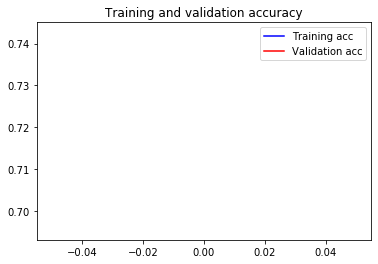

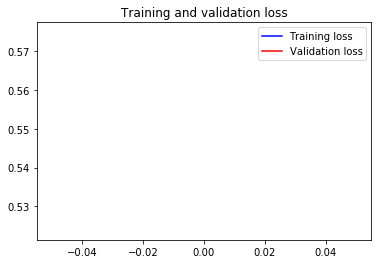

In [167]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [168]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [169]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [251]:
pred_list=[]
prob_list=[]
test_tweet=pd.read_excel("jd_final.xlsx")
for t in test_tweet['text']:
    r=predict(t) 
    pred_list.append(r["label"])
    prob_list.append(1-r["score"])
test_tweet['label']=pred_list
test_tweet['toxicity']=prob_list

In [255]:
test_tweet.columns
test_tweet=test_tweet.drop(['Unnamed: 0'],axis=1)

In [256]:
print(test_tweet[test_tweet['label']=="NEGATIVE"])

                   ids     user  \
2  1236032813943537665  Jaydeep   

                                                text     label  toxicity  
2  i hate you because you do politics on the basi...  NEGATIVE  0.948431  


In [257]:
test_tweet.to_csv('Neg_Tweets_new.csv')

In [250]:
x_test

array([[   0,    0,    0, ..., 3743,   60,  914],
       [   0,    0,    0, ...,  329,  143,    6],
       [   0,    0,    0, ..., 1268,   99,    1],
       ...,
       [   0,    0,    0, ...,    0,  863,  286],
       [   0,    0,    0, ..., 4364,   64,  481],
       [   0,    0,    0, ...,  558,  589,  609]])

### Confusion Matrix

In [123]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

20000/20000 [==============================] - 229s 11ms/step
Wall time: 3min 51s


In [240]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

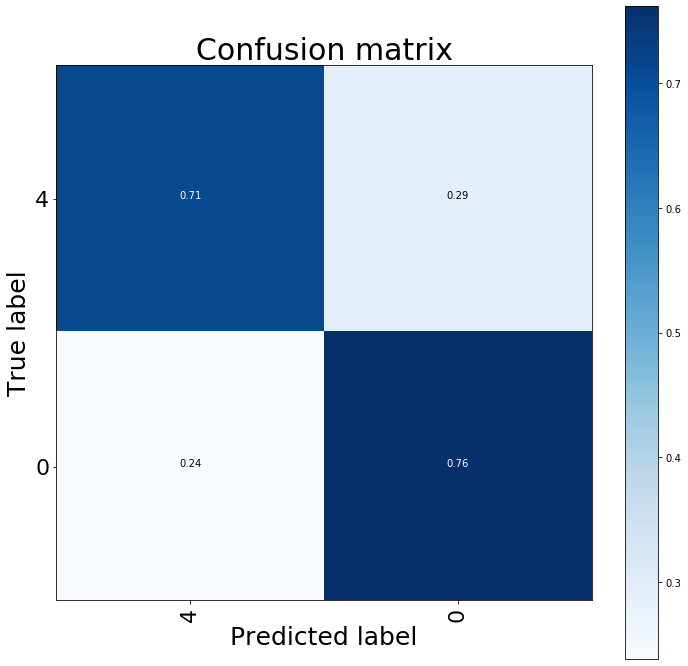

Wall time: 1.12 s


In [241]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [242]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.75      0.71      0.73     10130
    POSITIVE       0.72      0.76      0.74      9870

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000



### Accuracy Score

In [243]:
accuracy_score(y_test_1d, y_pred_1d)

0.73665

In [249]:
model.save('FINAL.model')

### Save model

In [247]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-03-07 04:14:19,981 : INFO : saving Word2Vec object under model_final.w2v, separately None
2020-03-07 04:14:19,997 : INFO : not storing attribute vectors_norm
2020-03-07 04:14:20,000 : INFO : not storing attribute cum_table
2020-03-07 04:14:20,444 : INFO : saved model_final.w2v
